In [214]:
#load Libraries
import scipy.io
import numpy as np
import binascii
import h5py
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import math
import time
from scipy import io
from scipy import signal
from scipy.io import savemat
from scipy.stats import pearsonr
from scipy.signal import butter, lfilter


In [215]:
# Digital filters
# Filter design
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Filtering 
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [216]:
# load data
pilot_bit =10 #length of pilot sequence
Fs=200000 # sampling rate
pilot_seq=[1,1,0,0,1,0,1,1,1,1]
bittime=100

mat = h5py.File('csworkshop_pilot_10_password13_2000ksampling_100_mili.mat')
# mat = scipy.io.loadmat('sigmetrics_pilot_10_qwerty_2000ksampling_100_mili_2_16_1.mat') # you can try any of the method for loading mat file
data=mat['data']
data=data[0] # reshaping to one diamensional array

# transmitted bits
loaded = scipy.io.loadmat("password13.mat") # load the corresponding bit files
sequence= loaded['t']

Text(0, 0.5, 'Amplitude')

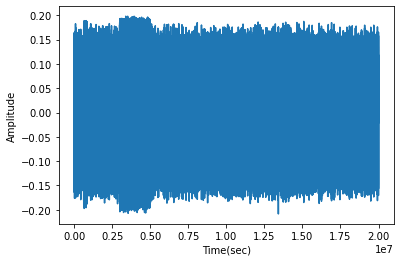

In [217]:
#data visulization
plt.plot(data)
plt.xlabel("Time(sec)")
plt.ylabel("Amplitude")# add axis label
# add new figure for fft

In [218]:
# Signal Processing and other steps


time=int(np.floor(len(data)/Fs)) # data collection time in seconds
bw=200 # filter bandwidth

MainData=np.zeros((int(len(data)/time),int(time)))
flitereddata=np.zeros((int(len(data)/time),int(time)))

N=int(len(data)/time)

for i in range (0,time):
    temp=data[i*N:(i+1)*N] 
    MainData[:,i]=temp.reshape(len(temp))

# filters center frequency tracking & filtering
ind=np.zeros((time,1));
fulldata=np.zeros((int(N/2),time));

for i in range (0,time):
    xdft = fft(MainData[:,i],N)
    xdft = xdft[0:int(np.ceil(N/2))]
    psdx = (1/(Fs*N)) * np.power(abs(xdft),2)
    psdx[1:len(xdft)-2] = 2*psdx[1:len(xdft)-2]
    fulldata[:,i]=psdx.reshape(len(psdx))

S1=np.transpose(fulldata)

for i in range (0,time):
    v,ind1=max([(v,ind1) for ind1,v in enumerate(S1[i,:])])
    realindex1=ind1
    realindex2=realindex1+120
    realindex3=realindex1-120
    newpsd2=S1[i,realindex2]
    newpsd3=S1[i,realindex3]
    max2=max(newpsd2,newpsd3)
    if max2==newpsd2:
        realindex4=realindex2
    else:
        realindex4=realindex3

    ind[i]=max(realindex1,realindex4)-60
    sIdx =ind[i]-np.ceil(bw/2)
    eIdx = ind[i]+np.ceil(bw/2)
    fpass=[sIdx,eIdx]
    y = butter_bandpass_filter(MainData[:,i], fpass[0], fpass[1], Fs, order=4)
    flitereddata[:,i]=y.reshape(len(y))

flitereddata=np.transpose(flitereddata)
time_signal=np.concatenate(flitereddata)

Text(0.5, 1.0, 'FFT of  unfiltered time domain signal')

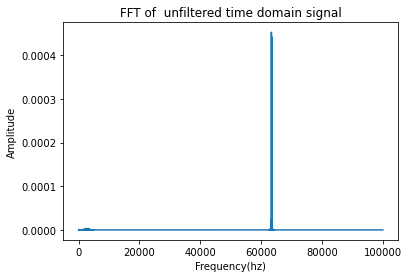

In [219]:
#plotting 1 second fft of  signal
step_freq= np.arange(0, Fs/2, 1)
plt.xlabel("Frequency(hz)")
plt.ylabel("Amplitude")
plt.plot(step_freq,fulldata[:,10]) ## change here
plt.title("FFT of  unfiltered time domain signal")


Text(0.5, 1.0, 'Filtered time domain signal')

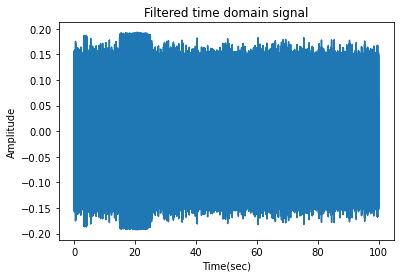

In [220]:
#plotting filtered signal
step_time= np.arange(0, 100, 1/Fs)
plt.xlabel("Time(sec)")
plt.ylabel("Amplitude")
plt.plot(step_time,time_signal)
plt.title("Filtered time domain signal")
# fft signal plot

In [257]:
chunk_size = int(Fs * (bittime/1000)) # bittime is in milliseconds
# print((bittime/1000) * Fs)

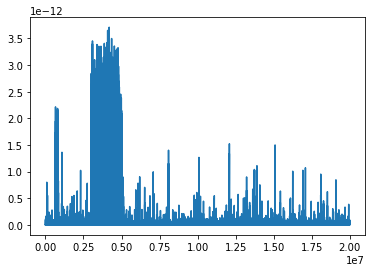

In [258]:
time_signal = np.square(time_signal)
plt.plot(time_signal)
# print(np.mean(time_signal))

In [259]:
mean_of_signal = np.mean(time_signal)
# print(mean_of_signal)

In [260]:
def convert(start_index, original_arr):
    interval = chunk_size # 100000 for 500 milliseconds
    end_index = start_index*interval + interval
#     print('start: ' + str(start_index*interval) + ' | end: ' + str(end_index))
    avg = np.mean(original_arr[start_index*interval : end_index])
    return avg - mean_of_signal


In [262]:
chunk_avg = []
total_chunks = int(len(time_signal) / chunk_size)
# print(total_chunks)

for i in range(0, int(total_chunks - 1), 1): # 20,000,000 - value was 199
    print(i)
    val = convert(i, time_signal[chunk_size/10:])
    chunk_avg.append(val)


0


TypeError: slice indices must be integers or None or have an __index__ method

Text(0.5, 1.0, 'Filtered time domain signal')

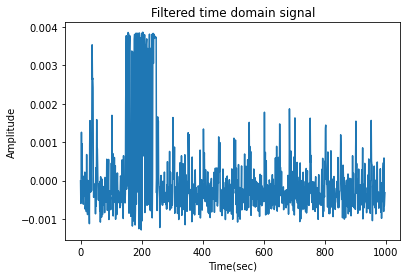

In [228]:
#plotting filtered signal
step_time= np.arange(0, 100, 1/Fs)
plt.xlabel("Time(sec)")
plt.ylabel("Amplitude")
plt.plot(chunk_avg)
plt.title("Filtered time domain signal")
# fft signal plot

In [229]:
bit_size = 10
start= 0
corr_list= []
for i in range(189):
    end = start + bit_size
    corr_val , _ = pearsonr(chunk_avg[start+i:start+i+bit_size], pilot_seq)
#     print(str(i) + str(' : ') + str(corr_val))
    corr_list.append(corr_val)

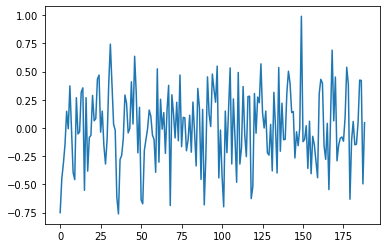

In [230]:
plt.plot(corr_list)

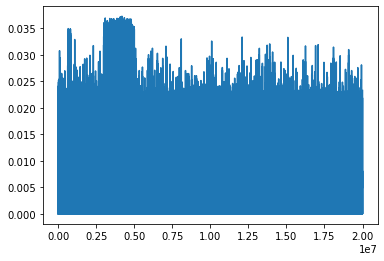

In [231]:
plt.plot(time_signal)

In [232]:
max_index = corr_list.index(max(corr_list))

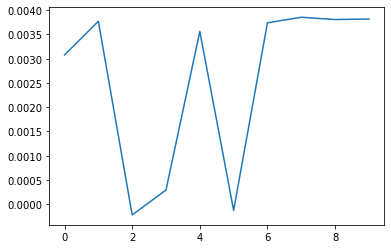

In [233]:
our_pilot = max_index
plt.plot(chunk_avg[our_pilot:our_pilot + 10])

In [234]:
avg_high = 0
avg_low = 0
count_one = 0
count_zero = 0

for i in range(len(pilot_seq)):
    if pilot_seq[i] == 1:
        avg_high += chunk_avg[our_pilot+i]
        count_one += 1
    else:
        avg_low += chunk_avg[our_pilot+i]
        count_zero += 1
        
avg_ones = avg_high / count_one
avg_zeros = avg_low / count_zero
threshold = (avg_ones + avg_zeros) / 2 # taking the average of averages of highs and lows

# print(avg_ones)
# print(avg_zeros)
# print(threshold)
        

In [235]:
decoded_seq = []

for i in range(100):
    if threshold <= chunk_avg[our_pilot + i]:
        decoded_seq.append(1)
    
    else:
        decoded_seq.append(0)
        

In [236]:
stolen_data = [] # decodes the 1's and 0's obtained from voltage values
temp_string = '' # used to hold one byte of data

for i in range(len(pilot_seq)):
    if decoded_seq[i] == pilot_seq[i]:
        pass
#         print(decoded_seq[i])
    else:
        print('Pilot sequence did not match')
        
len(decoded_seq) - 10

for i in range(len(pilot_seq), len(decoded_seq) - 10, 8): # start value of i from 10 because first 10 bits are pilot sequence
#     print(decoded_seq[i: i+8])
    
    for x in decoded_seq[i: i+8]:
        temp_string += str(x)
        
#     print(temp_string)
#     print(int(temp_string,2))
    stolen_data.append(chr(int(temp_string,2)))
    temp_string = ''

#     ascii_val = binascii.b2a_uu(decoded_seq[i: i+8])
    
# decoded_seq[len(decoded_seq) -10:]



In [237]:
stolen_data

['p', 'a', 's', 's', 'w', 'o', 'r', 'd', '1', '3']

In [200]:
len(time_signal)

20000000